# Notebook to investigate high count peaks

## Import packages and setup paths

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from poisson_atac.data import load_neurips

In [18]:
import pyranges as pr
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad
import os
import scvelo as scv
from statannotations.Annotator import Annotator
import scanpy as sc
import scipy
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from joblib import Parallel, delayed

In [19]:
from utils import contigency_table, cell_type_palette, plot_correlation

In [22]:
scv.set_figure_params()
sns.set_style("whitegrid")

In [20]:
save_path = '/s/project/poisson_atac/biological_analysis'

In [21]:
fig_path = '/s/project/poisson_atac/panels/revision2/Figure2/peak_analysis'

## Load data

In [7]:
adata = load_neurips(only_train=False, convert_counts = True)

adata.var.loc[:, ['Chromosome', 'Start', "End"]] = adata.var.index.to_series().str.split('-',expand=True).values
adata

AnnData object with n_obs × n_vars = 62501 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train', 'size_factor'
    var: 'feature_types', 'Chromosome', 'Start', 'End'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap'
    layers: 'counts'

In [9]:
## Load annotation

annotation = pd.read_csv(os.path.join(save_path, 'annotation', 'annotation.csv'), index_col=0)

annotation.index = annotation.Chromosome + '-' + annotation.Start.astype(str) + '-' + annotation.End.astype(str)

## Get peaks with high counts

In [28]:
threshold = [(0, 0.5), (0.5, 0.75), (0.75, 0.9), (0.9, 0.95), (0.95, 1)]

In [29]:
# compute average of cells with > 1 counts per peak
mean_high_count = np.array([
    (adata[idx, :].layers['counts']>1).mean(axis=0) for (key, idx) 
    in adata.obs.groupby('cell_type').indices.items()
]).squeeze()

In [30]:
max_ = mean_high_count.max(axis=0)

In [31]:
var_peaks = adata.var
var_peaks['max'] = max_

In [32]:
peaks_sets = {str(thr):
    var_peaks.iloc[
        np.where((var_peaks['max'] > np.quantile(max_, thr[0])) & (var_peaks['max'] <= np.quantile(max_, thr[1])))[0]] 
    for thr in threshold
}

## Length distribution of high count peaks

(0, 0.95)    110760
(0.95, 1)      5727
Name: Peak type, dtype: int64
(0, 0.95) vs. (0.95, 1): Mann-Whitney-Wilcoxon test two-sided, P_val:3.797e-269 U_stat=2.302e+08


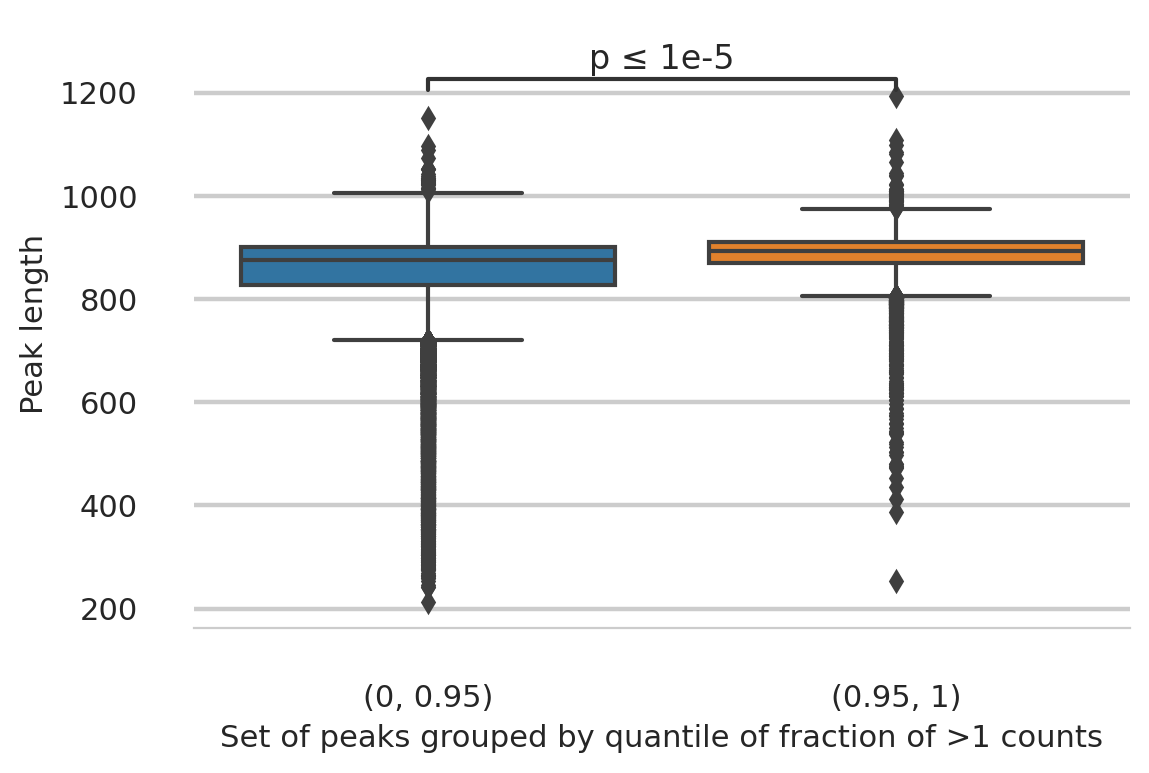

In [37]:
var_peaks = peaks_sets['(0.95, 1)']
length = var_peaks['End'].astype(int) - var_peaks['Start'].astype(int)
length_others = adata.var[~adata.var.index.isin(var_peaks.index)]
length_others = length_others['End'].astype(int) - length_others['Start'].astype(int)

order = ['(0, 0.95)', '(0.95, 1)']
sns_df = pd.DataFrame({'(0.95, 1)': length, '(0, 0.95)': length_others}).melt(var_name='Peak type', value_name='Peak length')
sns_df = sns_df[sns_df['Peak length'] < 1500] #filter two outliers

print(sns_df['Peak type'].value_counts())
ax = sns.boxplot(data=sns_df, x='Peak type', y='Peak length', order=order)

annot = Annotator(ax, [('(0.95, 1)', '(0, 0.95)')], data=sns_df, x='Peak type', y='Peak length', orient="v", order=order)
annot.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name=False, verbose=2)
annot.apply_test()

ax, test_results = annot.annotate(line_offset=0, line_offset_to_group=0)
ax.set(xlabel='Set of peaks grouped by quantile of fraction of >1 counts')
sns.despine(left=True)

plt.savefig(os.path.join(fig_path, 'length_distribution.png'), bbox_inches= "tight")
plt.savefig(os.path.join(fig_path, 'length_distribution.pdf'), bbox_inches= "tight")

## Overlap analysis

We want to load different annotations (e.g. superenhancers, distal enhancers, promoters) and see if they are enriched in high count peaks. 

### Superenhancers

In [41]:
sedb = [pd.read_csv(os.path.join(save_path, 'annotation', 'Human_Bone_marrow_hg38', file), sep='\t') for file in os.listdir(os.path.join(save_path, 'annotation', 'Human_Bone_marrow_hg38'))] 

In [42]:
sedb = pd.concat(sedb)

In [43]:
sedb = sedb.rename({'se_chr': 'Chromosome', 'se_start': 'Start', 'se_end':'End'}, axis=1)

In [44]:
sedb = pr.PyRanges(sedb)

In [45]:
sedb = sedb.overlap(pr.PyRanges(adata.var))

### Highly expressed genes

In [46]:
gex_data_path = os.path.join('/s/project/poisson_atac/anndata/', 'openproblems_bmmc_multiome_phase2.manual_formatting.output_rna.h5ad')

In [47]:
adata_gex = ad.read(gex_data_path)

In [48]:
top_n = 2000
highly_expressed_genes = adata_gex.var_names[np.argsort(adata_gex.X.mean(axis=0).A.squeeze())[-top_n:]]

In [49]:
he_regions = annotation[annotation.gene.isin(highly_expressed_genes)& (annotation.peak_type=='promoter') ] #

### Highly variable genes

In [50]:
sc.pp.highly_variable_genes(adata_gex, batch_key='batch', n_top_genes=2000)

In [51]:
hv_genes = adata_gex.var_names[adata_gex.var.highly_variable]

In [52]:
hv_regions = annotation[annotation.gene.isin(hv_genes)& (annotation.peak_type=='promoter') ]

### Distal elements

In [53]:
filter_ = ['dELS,CTCF-bound', 'dELS']

In [54]:
dist_ele = pd.read_csv(os.path.join(save_path, 'annotation', 'GRCh38-cCREs.bed'), sep='\t', header=None, names=['Chromosome', 'Start', 'End', 'Name1', 'Name2', 'Type'])

In [55]:
dist_ele = dist_ele[dist_ele.Type.isin(filter_)]

In [56]:
dist_ele = pr.PyRanges(dist_ele)

In [57]:
dist_ele = dist_ele.overlap(pr.PyRanges(adata.var))

### Perform overlap analysis

In [58]:
grs = (
    {
        'Distal regulatory elements': dist_ele, 
        'Super enhancers': sedb, 
        'Promoters of\nhighly variable genes (from RNA)': pr.PyRanges(hv_regions),
        'Promoters of\nhighly expressed genes (from RNA)': pr.PyRanges(he_regions)
    }
)

In [59]:
overlap = (
    pr.count_overlaps(grs, pr.PyRanges(adata.var)).df.loc[:, list(grs.keys())]>0
)*1

In [60]:
enrich = []
pval = []
for key, peak_set in peaks_sets.items():
    enrichment = {
        anno: scipy.stats.fisher_exact(
            contigency_table(grs, peak_set, M=overlap.shape[0], n = overlap[anno].sum(), anno=anno), 
            alternative='greater')[0] for anno in list(grs.keys())
    }
    pvalue = {
        anno: scipy.stats.fisher_exact(
            contigency_table(grs, peak_set, M=overlap.shape[0], n = overlap[anno].sum(), anno=anno), 
            alternative='greater')[1] for anno in list(grs.keys())
    }
    enrich.append(pd.DataFrame(enrichment, index=[key]))
    pval.append(pd.DataFrame(pvalue, index=[key]))

In [61]:
pval = pd.concat(pval)

In [62]:
pval = pval.melt(ignore_index=False).reset_index()

In [63]:
#adjust pvalue
pval['pval_adj'] = multipletests(pval['value'], method='fdr_bh', alpha=0.05)[1]

### Plot results

In [64]:
pval['variable'] = pd.Categorical(pval.variable, categories=grs.keys())

In [65]:
pval = pval.sort_values(['variable', 'index'])

4.361523118491451e-229
2.1828747968290474e-298
2.4717460770405365e-44
1.739459384067392e-223
6.730711203319008e-48
2.1599530196874767e-25
2.0272456451628424e-32
4.837995041719783e-87
1.4893180414547104e-188
5.522666818105565e-180
0.0


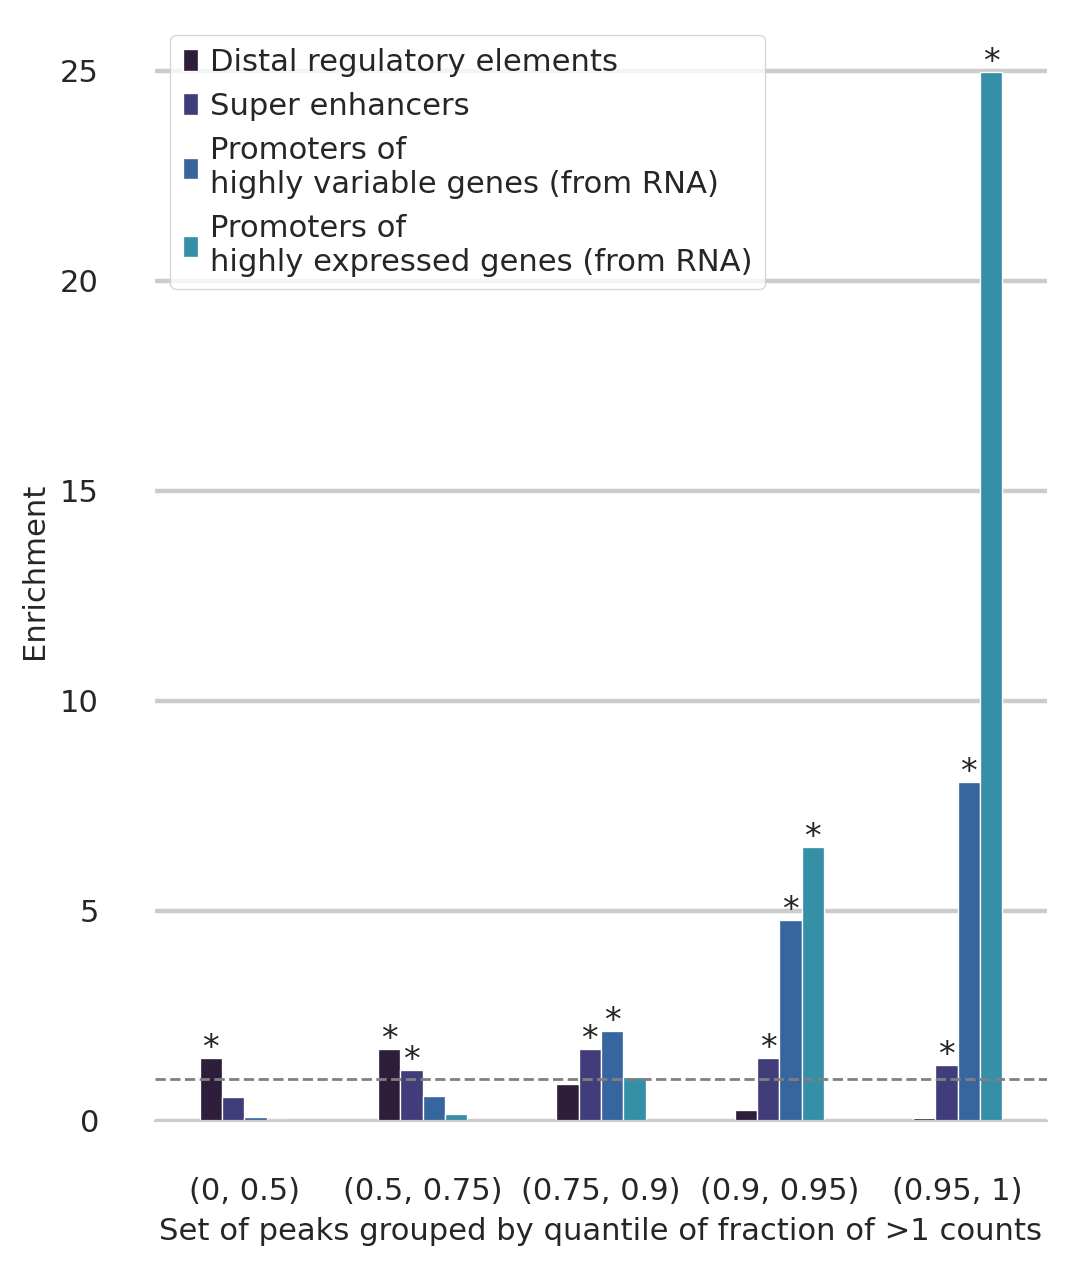

In [72]:
scv.set_figure_params()
sns.set_style("whitegrid")
with sns.color_palette("mako"):
    fig, ax = plt.subplots(figsize=(5.5,6.5))
    barplot = pd.concat(enrich).plot(kind='bar', ax = ax)
    for p, sig in zip(barplot.patches, pval['pval_adj']):
        if sig <=0.05:
            print(sig)
            barplot.text(p.get_x() + p.get_width() / 2., p.get_height(), 
                             '*', ha='center')
    
    plt.axhline(1, color='gray', linestyle='--', linewidth=1)
    plt.xticks(rotation=0)
    plt.ylabel('Enrichment')
    plt.xlabel('Set of peaks grouped by quantile of fraction of >1 counts')
    
    sns.despine(left=True)
    ax.xaxis.grid(False)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, 'enrichment_high_peaks.png'), bbox_inches= "tight")
    plt.savefig(os.path.join(fig_path, 'enrichment_high_peaks.pdf'), bbox_inches= "tight")

## Length distribution of regulatory elements

We want to rule out that promoters and superenhancers are enriched in high count peaks because they form a set of broader peaks (confounder)

In [41]:
# Get df with peak | length | regulatory element

overlap.index = adata.var.index
overlap = overlap.join(adata.var)
overlap['length'] = overlap['End'].astype(int) - overlap['Start'].astype(int)

df = overlap.loc[:, 
                 ['Distal regulatory elements', 'Super enhancers', 
                  'Promoters of\nhighly variable genes (from RNA)', 
                  'Promoters of\nhighly expressed genes (from RNA)','length']
                ]
df = df.reset_index().set_index(['index', 'length'])
df = df.mask(df == 0).stack().reset_index()
df = df.rename({'index': 'peak', 'level_2': 'regulatory_element'}, axis=1)
df.drop(0, inplace=True, axis=1)

In [42]:
sns_df = df[df['length'] < 1500] #filter two outliers

Distal regulatory elements vs. Super enhancers: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.301e-01 U_stat=1.474e+09
Super enhancers vs. Promoters of
highly expressed genes (from RNA): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.003e-01 U_stat=3.631e+07
Promoters of
highly expressed genes (from RNA) vs. Promoters of
highly variable genes (from RNA): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.683e-01 U_stat=1.385e+06
Distal regulatory elements vs. Promoters of
highly expressed genes (from RNA): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.551e-01 U_stat=6.977e+07
Super enhancers vs. Promoters of
highly variable genes (from RNA): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.122e-01 U_stat=2.886e+07
Distal regulatory elements vs. Promoters of
highly variable genes (from RNA): Mann-Whitney-Wilcoxon test two-s

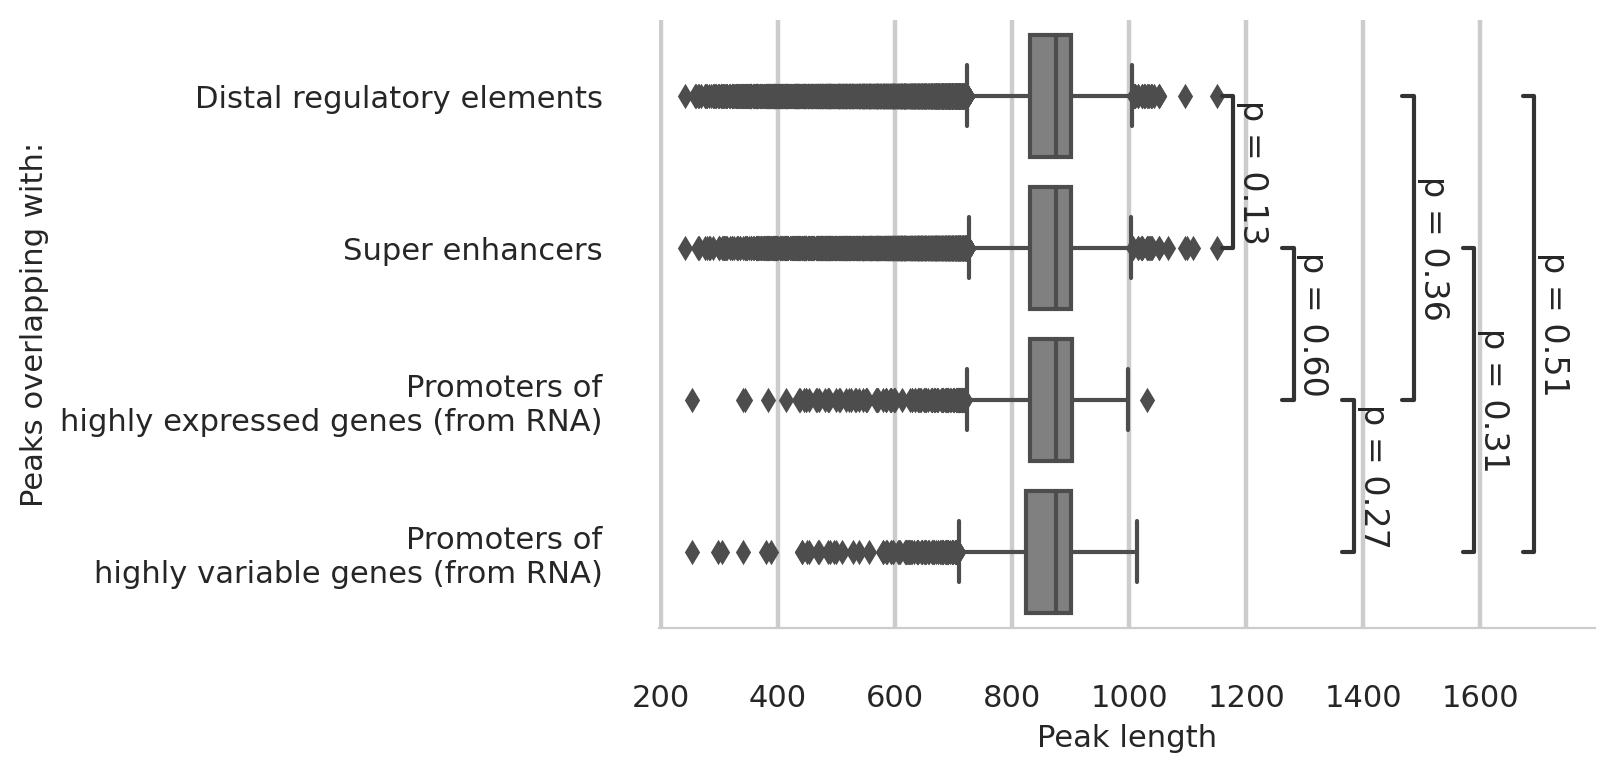

In [43]:
ax = sns.boxplot(data=sns_df, y='regulatory_element', x='length', orient='h', color='gray')

pairs = list(itertools.combinations(grs.keys(), 2))

annot = Annotator(ax, pairs, data=sns_df, y='regulatory_element', x='length', orient='h')
annot.configure(
    test='Mann-Whitney', 
    text_format='simple', 
    loc='inside', 
    show_test_name=False, 
    comparisons_correction="Benjamini-Hochberg", 
    verbose=2
)
annot.apply_test()
ax, test_results = annot.annotate(line_offset=0, line_offset_to_group=0)
ax.set(xlabel='Peak length', ylabel='Peaks overlapping with:')
sns.despine(left=True)
plt.savefig(os.path.join(fig_path, 'length_distribution_classes.png'), bbox_inches= "tight")
plt.savefig(os.path.join(fig_path, 'length_distribution_classes.pdf'), bbox_inches= "tight")

## Correlate gene expression with accessibility

### Restrict high count peaks to promoters

In [44]:
promoter = annotation[(annotation.peak_type == 'promoter') & annotation.gene.isin(adata_gex.var_names)]

In [45]:
test_regions = peaks_sets['(0.95, 1)'][peaks_sets['(0.95, 1)'].index.isin(promoter.index)]

In [46]:
test_regions =  test_regions.join(promoter, rsuffix='promoter')

### Restrict adata to similar size factor for correlation analysis

We restrict it to the 0.25-0.75 quantile

In [47]:
quant = adata.obs.size_factor.quantile([0.25, 0.75])
cell_restriction = adata.obs.size_factor.between(quant[0.25], quant[0.75])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


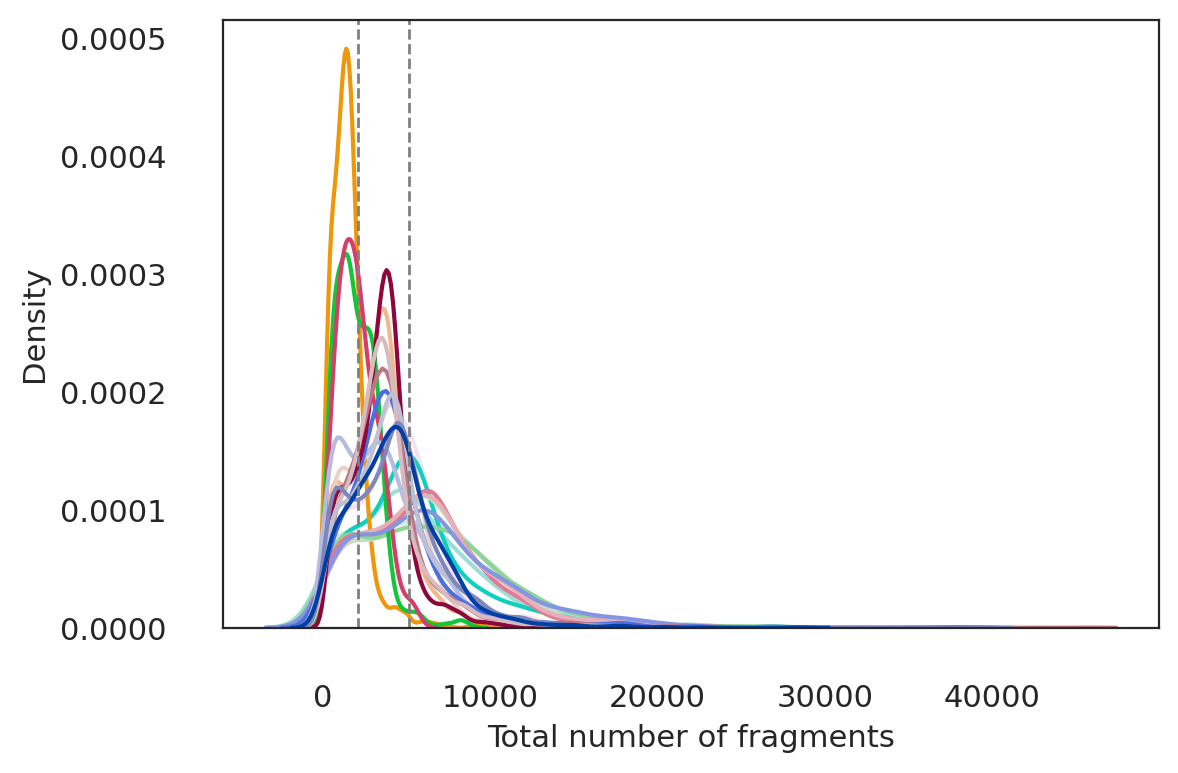

In [48]:
sns.set_style('white')
g = sns.kdeplot(data=adata.obs, hue='cell_type', x='size_factor', common_norm=False, palette=cell_type_palette)
g.legend().remove()
plt.axvline(quant[0.25], color='gray', linestyle='--', linewidth=1)
plt.axvline(quant[0.75], color='gray', linestyle='--', linewidth=1)
plt.xlabel('Total number of fragments')
plt.savefig(os.path.join(fig_path, 'fragment_size_distribution.pdf'))
plt.savefig(os.path.join(fig_path, 'fragment_size_distribution.png'))

### Compute correlation

In [49]:
def compute_corr(adata, adata_gex, region, gene):
    non_zero_cells = adata.obs_names[(adata[:, region].layers['counts'] > 0).A.squeeze()] 
    result = scipy.stats.spearmanr(adata[non_zero_cells, region].layers['counts'].A.squeeze(),adata_gex[non_zero_cells, gene].layers['counts'].A.squeeze())  
    return pd.DataFrame({"correlation": result.correlation, "pvalue": result.pvalue}, index=[region])

In [ ]:
corr = Parallel(n_jobs=-1)(
    delayed(compute_corr)(
        adata=adata[cell_restriction],
        adata_gex=adata_gex[cell_restriction],
        region=region,
        gene=df.gene
    ) 
    for region, df in tqdm(test_regions.iterrows()) #
)

In [ ]:
test_regions['correlation'] = corr['correlation'].values
test_regions['pvalue'] = corr['pvalue'].values


In [ ]:
test_regions = test_regions.sort_values('pvalue', ascending=True).reset_index().groupby(['index']).first()

In [65]:
test_regions['adj_pvalue'] = multipletests(test_regions['pvalue'].values, method='fdr_bh', alpha=0.05)[1]

In [66]:
test_regions.to_csv(os.path.join(save_path, 'correlations_size_factor_subset.csv'))

Number of significantly correlated genes:

In [80]:
((test_regions.pvalue < 0.05)).sum()

481

Percentage of genes:

In [81]:
481/3879

0.1240010311936066

### Plot highly correlated regions

In [10]:
test_regions = pd.read_csv(os.path.join(save_path, 'correlations_size_factor_subset.csv'), index_col=0)

In [11]:
test_regions

,feature_types,Chromosome,Start,End,max,feature_typespromoter,Chromosomepromoter,Startpromoter,Endpromoter,gene,peak_type,correlation,pvalue,adj_pvalue
index,,,,,,,,,,,,,,
chr1-100132564-100133476,ATAC,chr1,100132564,100133476,0.059788,ATAC,chr1,100132564,100133476,SASS6,promoter,0.010651,0.443394,0.791863
chr1-10032411-10033292,ATAC,chr1,10032411,10033292,0.133333,ATAC,chr1,10032411,10033292,UBE4B,promoter,-0.002502,0.804715,0.941058
chr1-100351119-100351940,ATAC,chr1,100351119,100351940,0.077146,ATAC,chr1,100351119,100351940,CDC14A,promoter,0.002558,0.878062,0.965680
chr1-10210009-10210911,ATAC,chr1,10210009,10210911,0.089855,ATAC,chr1,10210009,10210911,KIF1B,promoter,0.006279,0.605178,0.870064
chr1-10398494-10399383,ATAC,chr1,10398494,10399383,0.110145,ATAC,chr1,10398494,10399383,PGD,promoter,0.002964,0.797781,0.936053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX-48801394-48802331,ATAC,chrX,48801394,48802331,0.118841,ATAC,chrX,48801394,48802331,HDAC6,promoter,0.022352,0.036996,0.352043
chrX-48957778-48958683,ATAC,chrX,48957778,48958683,0.064609,ATAC,chrX,48957778,48958683,OTUD5,promoter,-0.007666,0.511050,0.822474
chrX-49043174-49044091,ATAC,chrX,49043174,49044091,0.072464,ATAC,chrX,49043174,49044091,TFE3,promoter,0.008843,0.469778,0.802953


Gene: CD74, n=7000
Gene: SLC4A1, n=775
Gene: CR1L, n=1917
Gene: MAFB, n=1845


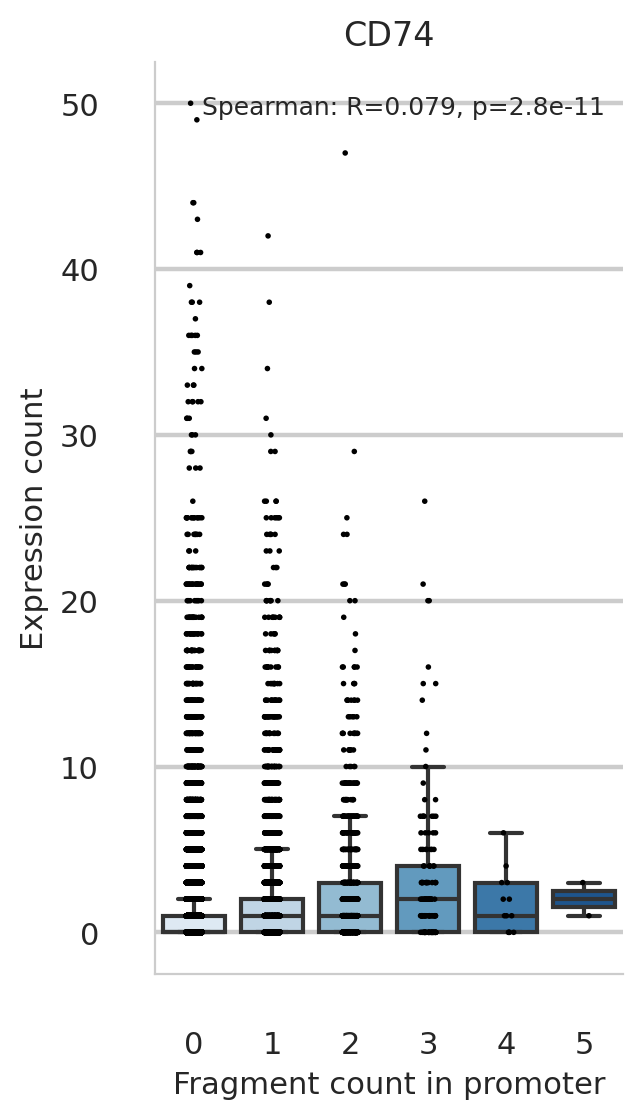

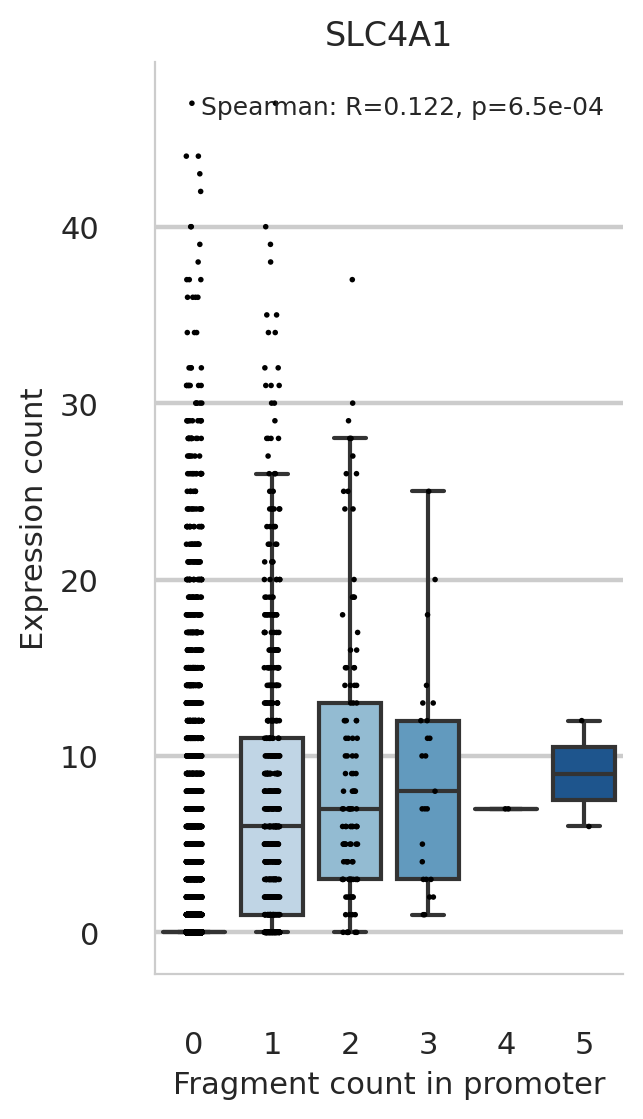

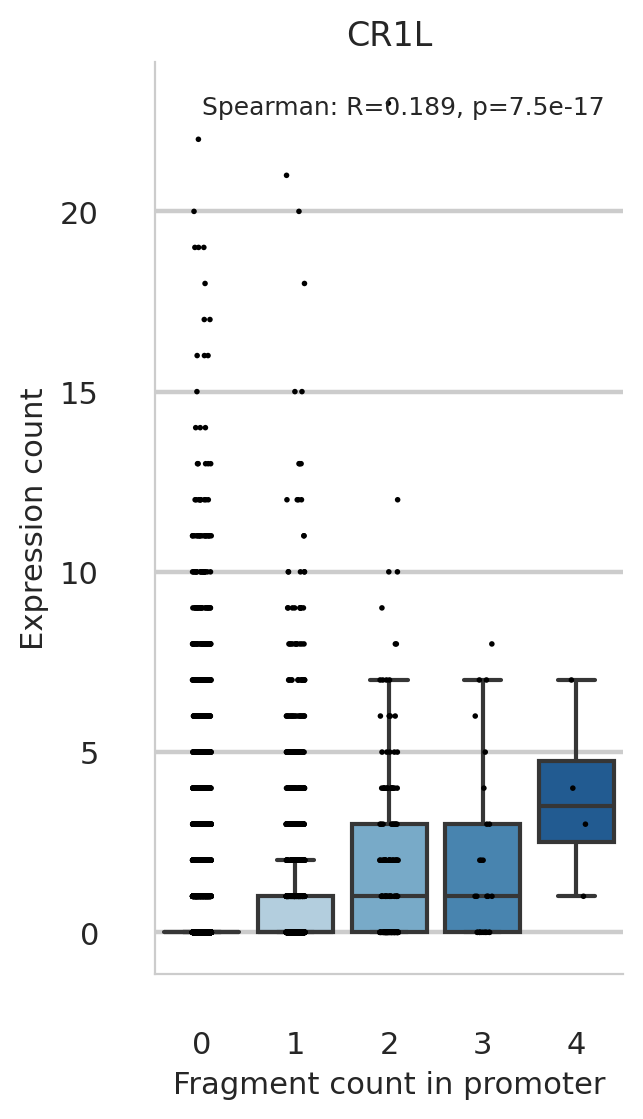

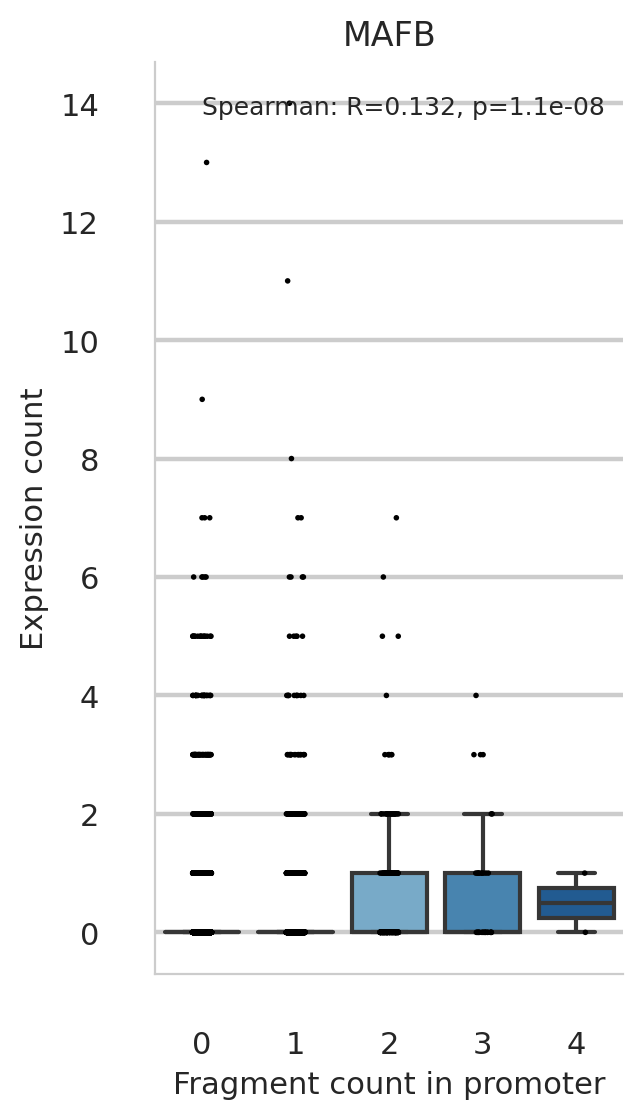

In [26]:
for gene in ['CD74', 'SLC4A1', 'CR1L', 'MAFB']:
    plot_correlation(test_regions, adata, adata_gex, gene, fig_path=fig_path)

In [57]:
scipy.stats.wilcoxon(test_regions.correlation, y=np.zeros(test_regions.shape[0]), alternative='greater')

WilcoxonResult(statistic=3954870.0, pvalue=0.002926130260736238)